# Statistical model
1. Single LinReg
2. One LinReg per model
3. One LinReg per model but include operators in training data.

In [30]:
# Load data
from src.util import read_results
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from src.util import model_operators, train_and_score, train_test_validate_split, feature_transform_pipe, eval_result
import numpy as np
result_df = read_results(from_parquet=True)
result_df.head()
%load_ext autoreload
%autoreload 2
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

from src.util import all_cat_features
list_features = [x for x in result_df.columns if isinstance(result_df[x].iloc[0], np.ndarray)]
print(list_features)
result_df = result_df.drop(columns=list_features)
cat_features = list(set(result_df.columns).intersection(all_cat_features))
result_df[cat_features] = result_df[cat_features].astype(str)

train, test, validate = train_test_validate_split(result_df)
estimator_results = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['features', 'r_S', 'c_S', 'nnz_S', 'sparsity_S', 'morpheusfi_eis', 'morpheusfi_nis']
train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['v100' 'CPU 08c' 'p100' 'CPU 16c' '1080' 'CPU 32c' '2080' 'a40']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '2080' 'CPU 16c' '1080' 'CPU 08c' 'v100' 'p100' 'a40']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


## Stat.1 Single LinReg


In [31]:
all_features = ['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'compute_unit', 'complexity_ratio',
       'times_mean', 'dataset_type', 'compute_type', 'label', 'features',
       'parallelism', 'mem_mat_read', 'mem_mat_write', 'mem_fac_read',
       'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat', 'comp_rmm_mat',
       'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac', 'comp_mat_col_major',
       'comp_fac_col_major', 'comp_scalar_dense', '13', '14',
       'comp_matrix_dense', 'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu__architecture', 'gpu__number_of_sm', 'gpu__cores',
       'gpu_cache_size_l1', 'gpu_cache_size_l2', 'gpu_clock_speed_base',
       'gpu_clock_speed_max_boost', 'gpu_memory_bus_width', 'gpu_memory_size',
       'gpu_memory_clock', 'gpu_memory_bandwidth',
       'gpu_processing_power_half_precision',
       'gpu_processing_power_single_precision',
       'gpu_processing_power_double_precision', 'materialized_times_mean',
       'time_saved']
meta_features = ['dataset_type', 'features', 'comp_ratio', 'tr', 'fr', 'compute_unit', 'materialized_times_mean']
dep = ['speedup', 'times_mean', 'label', 'time_saved','materialized_times_mean']
indep = list(set(all_features).intersection(result_df.columns) - set(dep) - set(meta_features))

In [32]:
linregs = {}

2024-04-09 16:48:58.720 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:06.104 | INFO     | src.util:eval_model:482 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['comp_fac_col_major', 'gpu__cores', 'gpu_memory_clock', 'comp_rmm_mat',
       'mem_mat_write', 'gpu_memory_bus_width', 'gpu_clock_speed_base',
       'comp_mat_col_major', 'mem_write_matrix_dense', 'cardinality_T', '14',
       'morpheusfi_ns', 'mem_read_scalar_dense', 'FR', 'gpu_cache_size_l2',
       'cardinality_S', 'comp_scalar_fac', 'mem_read_rowsum', 'TR',
       'comp_lmm_fac', 'mem_mat_read', 'num_cores', 'morpheusfi_q', 'comp_fac',
       'comp_colsum', 'c_T', 'mem_fac_write', 'morpheusfi_p', '13',
       'gpu_processing_power_double_precision', 'comp_rmm_fac',
       'mem_write_colsum', 'gpu__architecture', 'selectivity', 'nnz_T',
       'parallelism', 'mem_write_rowsum', 'gpu__number_of_sm',
       'comp

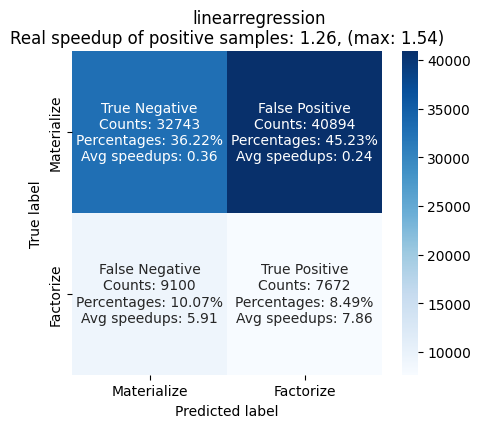

In [33]:
target_col = 'time_saved'
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]

stat1 = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True, target_col=target_col)

# Test only on models
locator = test[test.operator.isin(model_operators)].index
y_pred = pd.Series(stat1.predict(X_test.loc[locator]), index=X_test.loc[locator].index)
resul = eval_result(y_test.loc[locator], y_pred > 1.2, full_dataset=test.loc[locator], model_name='LINR.1', target_col=target_col)

estimator_results['LINR.1'] = resul[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

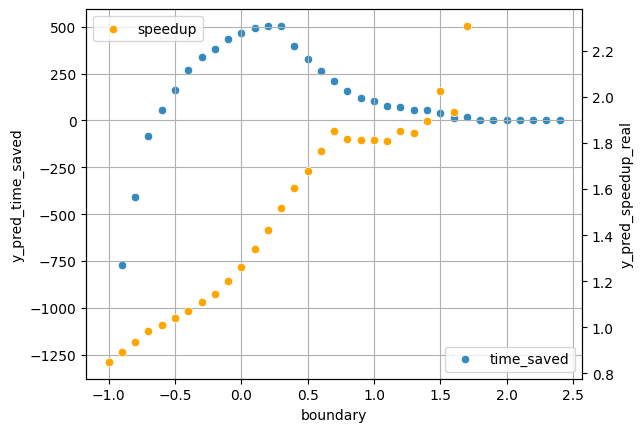

In [34]:
from src.util import eval_result

def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1, target_col=target_col, full_dataset=test):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved')
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange')
    ax.grid()
    ax.legend(loc='lower right')
    return ax
plot_boundary(y_test, pd.Series(stat1.predict(X_test), index=X_test.index), upper=2.5, target_col=target_col)

In [35]:
linregs['LINR.1'] = (stat1, 0.0)

## LINR.2 Single linreg on only Models

2024-04-09 16:49:13.570 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-04-09 16:49:15.002 | INFO     | src.util:eval_model:482 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['comp_fac_col_major', 'gpu__cores', 'gpu_memory_clock', 'comp_rmm_mat',
       'mem_mat_write', 'gpu_memory_bus_width', 'gpu_clock_speed_base',
       'comp_mat_col_major', 'mem_write_matrix_dense', 'cardinality_T', '14',
       'morpheusfi_ns', 'mem_read_scalar_dense', 'FR', 'gpu_cache_size_l2',
       'cardinality_S', 'comp_scalar_fac', 'mem_read_rowsum', 'TR',
       'comp_lmm_fac', 'mem_mat_read', 'num_cores', 'morpheusfi_q', 'comp_fac',
       'comp_colsum', 'c_T', 'mem_fac_write', 'morpheusfi_p', '13',
       'gpu_processing_power_double_precision', 'comp_rmm_fac',
       'mem_write_colsum', 'gpu__architecture', 'selectivity', 'nnz_T',
       'parallelism', 'mem_write_rowsum', 'gpu__number_of_sm',
       'complexity_ratio', 'gpu_memory_bandwidth', 'mem_write_scalar_dense',
       'sparsity_T', 'comp_lmm_mat', 'mem_read_colsum', 'gpu_cache_s

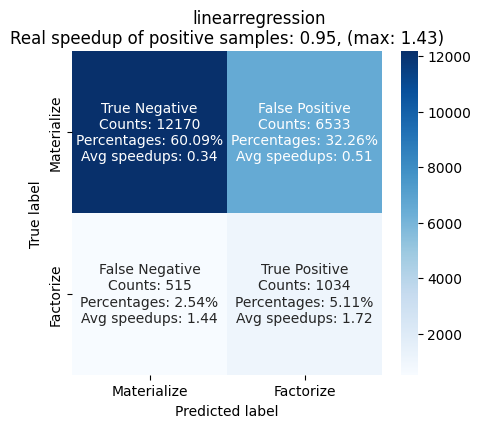

In [36]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[target_col]
X_test, y_test = test[indep], test[target_col]
X_validate, y_validate = validate[indep], validate[target_col]
stat2 = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

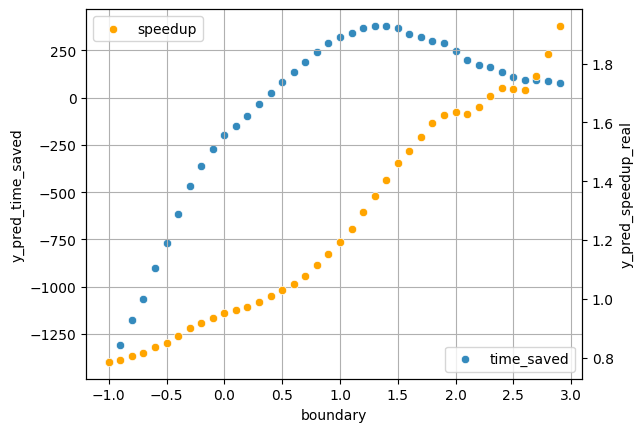

In [37]:
y_pred = pd.Series(stat2.predict(X_test), index=X_test.index)
plot_boundary(y_test, y_pred, upper=3.0, full_dataset=test)

In [38]:
estimator_results['LINR.2'] = eval_result(y_test, y_pred>1.5, full_dataset=test, model_name='LINR.2')[0]
linregs['LINR.2'] = (stat2, 1.5)

## LINR.3 Linear Regression predict runtime for F & M
Two regression, predict runtime for both F and M. Select lowest

In [39]:
from src.analytical_model import LinRegEnsemble


train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# Add a constant column to the dataframes
train['constant'] = 1
test['constant'] = 1
validate['constant'] = 1

X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [40]:
stat3 = LinRegEnsemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='constant',
)
pred = stat3.predict(test, X_test)


2024-04-09 16:49:18.114 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by constant
2024-04-09 16:49:18.125 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


2024-04-09 16:49:19.638 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:21.168 | INFO     | src.analytical_model:create_linreg_ensemble:211 - Created a linear regression ensemble for the analytical model with 2 models
2024-04-09 16:49:21.171 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


In [41]:
pred

,times_mean,materialized_times_mean
32,9.438477,2.114014
34,6.786621,1.958374
35,5.764648,1.179932
143,5.758545,1.179810
158,9.703613,2.302856
...,...,...
343757,0.080078,-0.638672
343809,-0.443359,-0.260498
343829,0.263184,-0.551147
343846,0.551758,0.085815


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

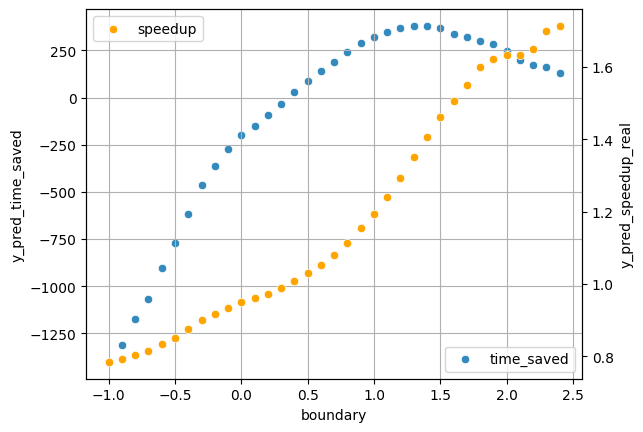

In [42]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5, full_dataset=test)

In [43]:
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 1.4, full_dataset=test, target_col='time_saved')
estimator_results['LINR.3'] = res[0]
linregs['LINR.3'] = (stat3, 1.5)


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat.4 Separate regressors for each model type

2024-04-09 16:49:24.159 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by operator
2024-04-09 16:49:24.173 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-04-09 16:49:25.219 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:26.293 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:27.311 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:28.227 | INFO     | src.analytical_model:create_linreg_ensemble:211 - Created a linear regression ensemble for the analytical model with 4 models
2024-04-09 16:49:28.231 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

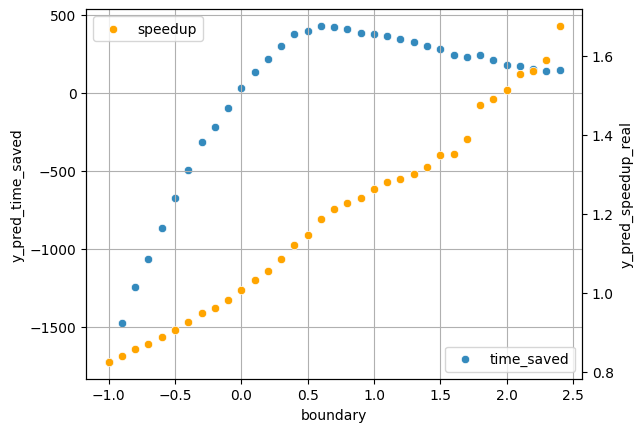

In [44]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]
split_by = 'operator'
stat4 = LinRegEnsemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='operator',
)
pred = stat4.predict(test, X_test)
plot_boundary(y_test, pred.time_saved, upper=2.5, full_dataset=test)

In [45]:
res = eval_result(y_test, y_pred = pred.time_saved, full_dataset=test)
estimator_results['LINR.4'] = res[0]
linregs['LINR.4'] = (stat4, 0.)


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat. 5 split CPU and GPU

In [46]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

split_by = 'compute_type'
stat5 = LinRegEnsemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = stat5.predict(test, X_test)


2024-04-09 16:49:31.281 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by compute_type
2024-04-09 16:49:31.293 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-04-09 16:49:32.387 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:33.668 | INFO     | src.analytical_model:create_linreg_ensemble:211 - Created a linear regression ensemble for the analytical model with 2 models
2024-04-09 16:49:33.671 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

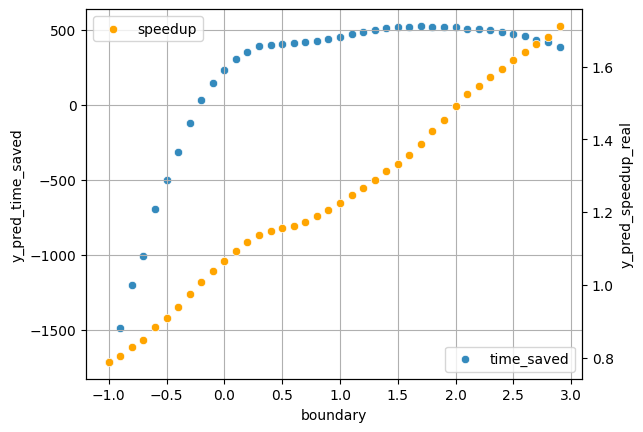

In [47]:
res = eval_result(y_test, y_pred = pred.time_saved > 0.1, full_dataset=test)
estimator_results['LINR.5'] = res[0]
res[0]
plot_boundary(y_test, pred.time_saved, upper=3.0, full_dataset=test)
linregs['LINR.5'] = (stat5, 0.1)

2024-04-09 16:49:36.810 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

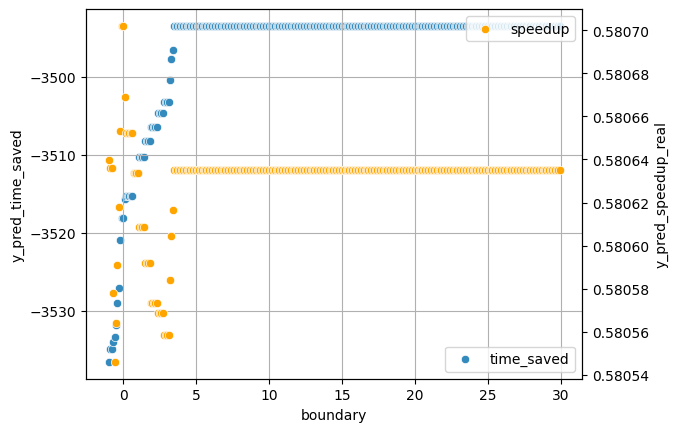

In [48]:
loc = validate.compute_type == 'cpu'
pred = stat5.predict(validate.loc[loc], X_validate.loc[loc])
res = eval_result(y_validate.loc[loc], y_pred= pred.time_saved > 0.0, full_dataset=validate.loc[loc], target_col='time_saved')
plot_boundary(y_validate.loc[loc], pred.time_saved, upper=30.0, full_dataset=validate.loc[loc])

## Stat.6 Split by F,M,operator

In [49]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator']
stat6 = LinRegEnsemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = stat6.predict(test, X_test)

2024-04-09 16:49:42.314 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by ['operator']
2024-04-09 16:49:42.326 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-04-09 16:49:43.272 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:44.255 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:45.233 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:46.188 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:47.118 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:48.077 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:49.039 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:49.986 | INFO     | src.analytical_model:create_linr

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

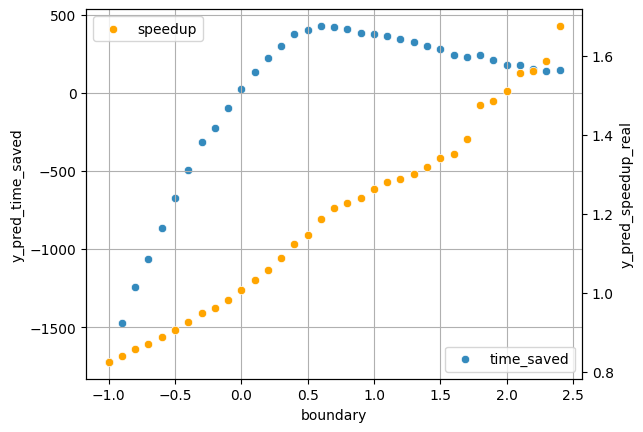

In [50]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5, full_dataset=test)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.6, full_dataset=test, target_col='time_saved')
estimator_results['LINR.6'] = res[0]
linregs['LINR.6'] = (stat6, 0.6)

## Stat.7 Split by F,M,operator

In [51]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator', 'compute_type']
stat7 = LinRegEnsemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = stat7.predict(test, X_test)

2024-04-09 16:49:53.019 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'compute_type']
2024-04-09 16:49:53.035 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-04-09 16:49:53.913 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:54.797 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:55.682 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:56.524 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:57.351 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:58.168 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:59.003 | INFO     | src.util:feature_transform_pipe:446 - ['gpu__architecture', 'compute_type', 'join', 'operator']
2024-04-09 16:49:59.851 | INFO     | src.util:feature_transform_pipe:

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:500: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

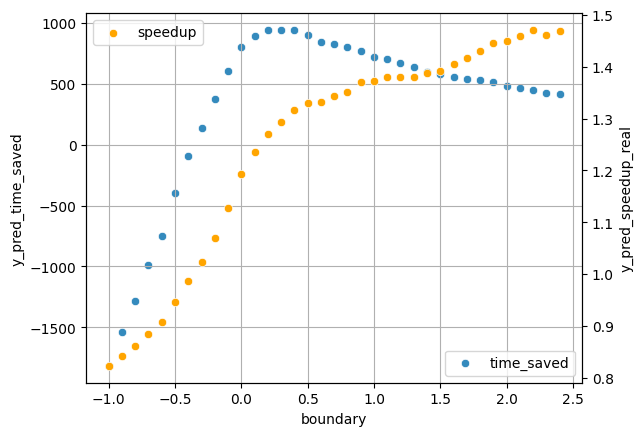

In [52]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5, full_dataset=test)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
estimator_results['LINR.7'] = res[0]

## LINR.8 (not included)

In [53]:
# train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
# X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
# X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

# split_by = ['compute_type']
# linreg_f_m = create_linreg_ensemble(
#     train,
#     X_train,
#     y_train,
#     clf_func=feature_transform_pipe,
#     clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
#     rfecv=False,
#     split_by=split_by,
# )
# pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

In [54]:
# y_pred = (pred.materialized_times_mean - pred.times_mean)
# plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
# res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
# # estimator_results['LINR.8'] = res[0]

In [55]:
# train, test, validate = train_test_validate_split(result_df)
# X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
# X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
# # X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

# split_by = ['compute_type']
# linreg_f_m = LinRegEnsemble(
#     train,
#     X_train,
#     y_train,
#     clf_func=feature_transform_pipe,
#     clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
#     rfecv=False,
#     split_by=split_by,
# )
# pred = linreg_f_m.predict(test, X_test)
# y_pred = (pred.materialized_times_mean - pred.times_mean)
# plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
# res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test, target_col='time_saved')
# estimator_results['LINR.9'] = res[0]
# linregs['LINR.9'] = (linreg_f_m, 0.)

# Analysis

In [56]:
import matplotlib
colors = ['#F5F5F5', '#DAE8FC', '#D5E8D4', '#FFE6CC', '#FFF2CC','#F8CECC', '#E1D5E7']
pal = sns.color_palette([matplotlib.colors.to_rgba(x) for x in colors])
pal

[(0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
 (0.8549019607843137, 0.9098039215686274, 0.9882352941176471),
 (0.8352941176470589, 0.9098039215686274, 0.8313725490196079),
 (1.0, 0.9019607843137255, 0.8),
 (1.0, 0.9490196078431372, 0.8),
 (0.9725490196078431, 0.807843137254902, 0.8),
 (0.8823529411764706, 0.8352941176470589, 0.9058823529411765)]

/tmp/ipykernel_157565/852556913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
/tmp/ipykernel_157565/852556913.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_157565/852556913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
/tmp/ipykernel_157565/852556913.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotat

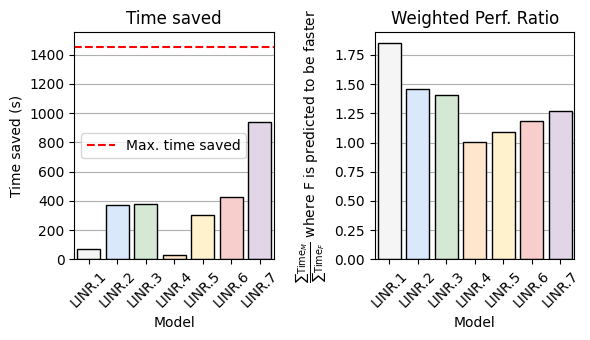

In [64]:
resdf = pd.DataFrame(estimator_results.values())
resdf['Model'] = estimator_results.keys()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
palette = []
f, axs = plt.subplots(1,2, figsize=(0.75*8,3.5))
labels = ["Time saved (s)", "$\\frac{\sum\mathrm{Time}_M}{\sum\mathrm{Time}_F}$ where F is predicted to be faster"]
titles = ["Time saved", 'Weighted Perf. Ratio', "Performance"]
max_time_saved = resdf.y_true_time_saved.max()
max_speedup = resdf.y_pred_speedup_real.max()
for ax, var, label, title in zip(axs, ['y_pred_time_saved', 'y_pred_speedup_real'], labels, titles):
    sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    # ax.set_xlabel("Cost Model")
    ax.set_title(title)
    if var =='y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max. time saved")
        ax.set_ylim(top=max_time_saved+100)
        ax.legend()
    elif var == 'y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max speedup")
        ax.legend()
    
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/stat-models-compare.pdf", bbox_inches='tight')

In [58]:
resdf.y_pred_time_saved / resdf.y_true_time_saved

0    0.050145
1    0.261838
2    0.267885
3    0.019723
4    0.215163
5    0.303503
6    0.666174
dtype: float64

In [59]:
y_true = y_validate
y_pred = stat7.predict(validate, X_validate)

2024-04-09 16:50:11.298 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


In [60]:
# res = pd.DataFrame(
#     {
#         "stat_y_true": (y_true.materialized_times_mean - y_true.times_mean)> 0,
#         "stat_y_pred": (y_pred.materialized_times_mean - y_pred.times_mean) > 0,
#     }
# )
# res.to_csv("evaluation/predictions/stat_label.csv")

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3728/43526 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' 'v100' 'CPU 16c' 'CPU 32c' 'CPU 08c' '2080' 'a40']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1549/18703 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'a40' '1080' '2080' 'v100' 'CPU 16c' 'CPU 32c']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


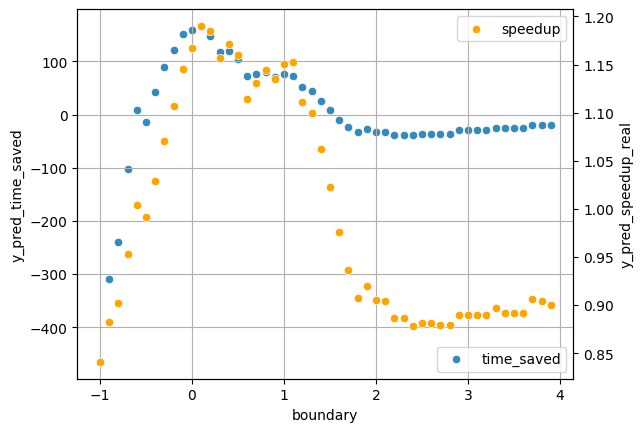

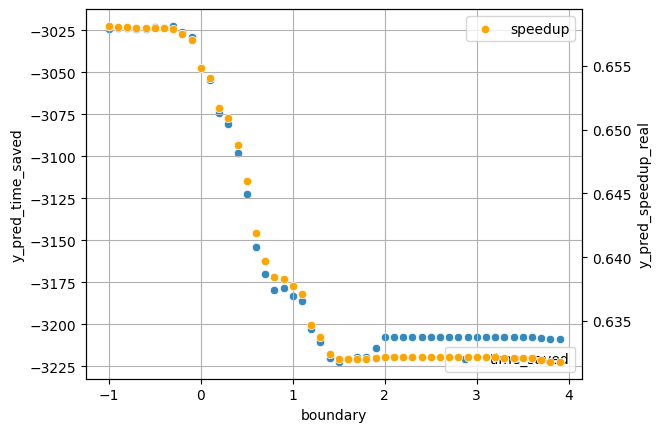

2024-04-09 16:50:14.920 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


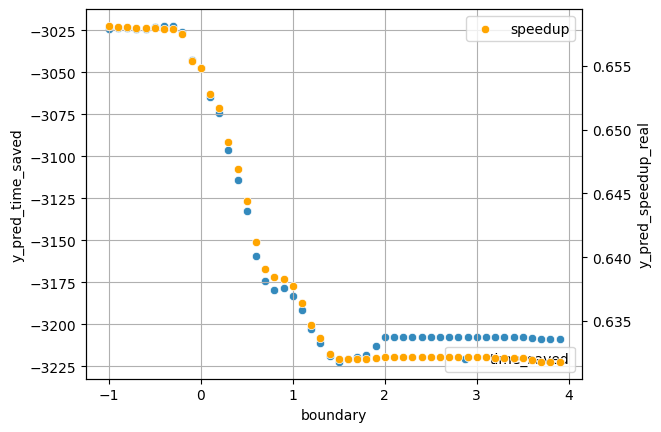

2024-04-09 16:50:16.556 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


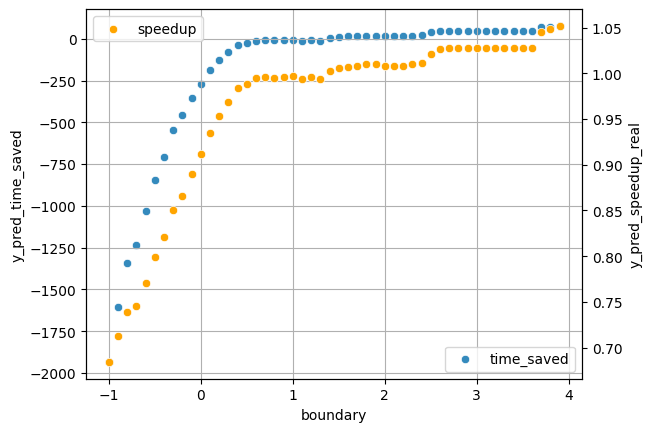

2024-04-09 16:50:18.182 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


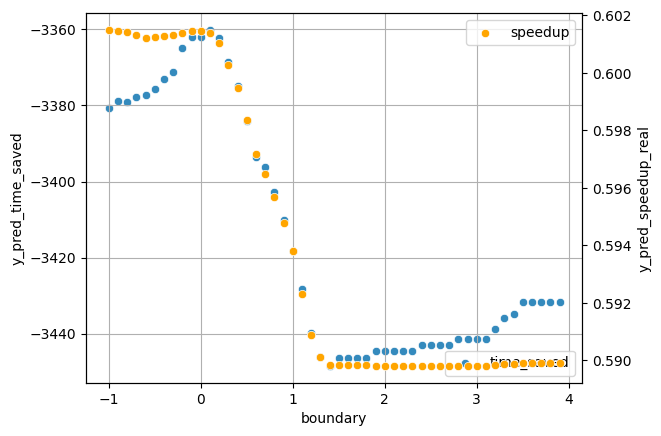

2024-04-09 16:50:19.749 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


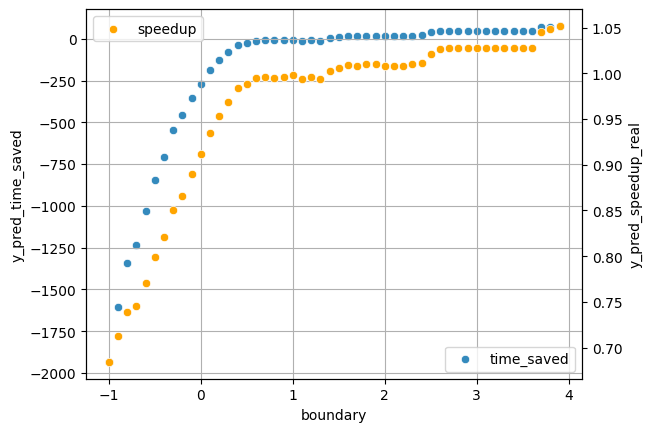

In [61]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_validate, y_validate = validate[indep], validate["time_saved"]
validate['constant'] = 1
eval_results = {}
for name,(model, boundary) in linregs.items():
    if name in ["LINR.1", "LINR.2"]:
        y_pred = model.predict(X_validate)
    else:
        y_pred = model.predict(validate, X_validate)
    if isinstance(y_pred, pd.DataFrame):
        if len(y_pred.columns) > 1:
            y_pred = (y_pred.materialized_times_mean - y_pred.times_mean)
        else:
            y_pred = y_pred.time_saved
    y_pred = pd.Series(y_pred)
    y_pred.index = y_validate.index
    plot_boundary(y_validate, y_pred, target_col='time_saved', upper=4.0, full_dataset=validate)
    plt.show()
    eval_results[name] = eval_result(y_validate, y_pred>boundary, full_dataset=validate, model_name=name)[0]
    
    if name in ['LINR.1', 'LINR.5']:
        pd.DataFrame(
        {
            "stat_y_true": y_validate> 0,
            "stat_y_pred": y_pred > boundary,
        }).to_csv(f"evaluation/predictions/{name.replace('.','')}_label.csv")

/tmp/ipykernel_157565/1485204420.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_results, x='index', y='y_pred_time_saved', palette=pal)
/tmp/ipykernel_157565/1485204420.py:8: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(data=merged_results, x='index', y='y_pred_time_saved', palette=pal)


<Axes: xlabel='index', ylabel='y_pred_time_saved'>

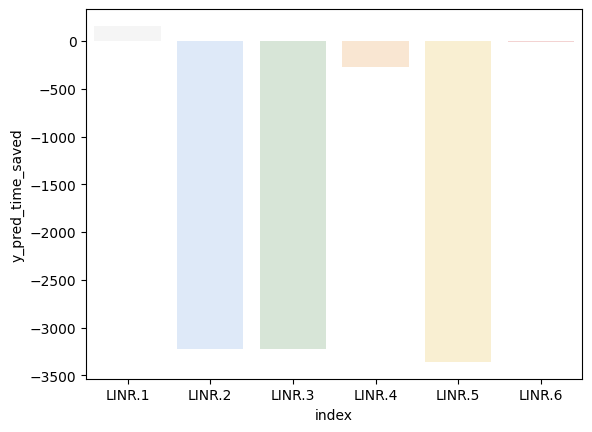

In [62]:
eval_results_df = pd.DataFrame(eval_results).T
merged_results = (
    eval_results_df.reset_index()
    .merge(pd.json_normalize(eval_results_df.speedup), left_index=True, right_index=True,)
    .drop(columns="speedup")
)
merged_results
sns.barplot(data=merged_results, x='index', y='y_pred_time_saved', palette=pal)

In [63]:
merged_results
merged_results['fraction_of_optimal_time_saved'] = merged_results.y_pred_time_saved / merged_results.y_true_time_saved
merged_results

,index,accuracy,precision,recall,f1,y_true_mat_time,y_true_fact_time,y_true_best_time,y_true_time_saved,y_true_speedup_avg,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,LINR.1,0.877,0.348865,0.260018,0.297959,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,947.004490,727.915433,158.693416,3.153974,1.167574,"(292, 7.995018483478523, 377.7824724172084)","(545, 0.5602396094171403, -219.0890563947757)","(9519, 0.366078918363674, -15238.694988022067)","(831, 2.619028502113923, 1289.6656096827558)",0.095171
1,LINR.2,0.88719,0.386623,0.211042,0.273041,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,8756.857084,5119.950358,-3222.434402,2.216404,0.632010,"(237, 4.7303457569142315, 414.47232329898395)","(376, 0.6318176378521012, -3636.906725480514)","(9688, 0.36668790041327043, -11820.87731893633)","(886, 3.8260340158507065, 1252.97575880098)",-1.932555
2,LINR.3,0.88719,0.386623,0.211042,0.273041,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,8756.857084,5119.950358,-3222.434402,2.216404,0.632010,"(237, 4.7303457569142315, 414.47232329898395)","(376, 0.6318176378521012, -3636.906725480514)","(9688, 0.36668790041327043, -11820.87731893633)","(886, 3.8260340158507065, 1252.97575880098)",-1.932555
3,LINR.4,0.801198,0.196694,0.317898,0.243022,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,3028.728525,2219.772900,-268.023352,1.426664,0.911506,"(357, 4.947236305274179, 540.932272807979)","(1458, 0.5646314216281619, -808.9556244886784)","(8606, 0.3447366021731692, -14648.828419928164)","(766, 3.5832829261743044, 1126.5158092919849)",-0.160739
4,LINR.5,0.892554,0.432937,0.22707,0.297897,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,8429.457052,4850.511845,-3360.174485,2.552945,0.601377,"(255, 5.101008891630933, 218.77072220187006)","(334, 0.6075676286877572, -3578.9452069313784)","(9730, 0.36866477112584206, -11878.838837485464)","(868, 3.698388035790912, 1448.677359898094)",-2.015160
5,LINR.6,0.895146,0.463977,0.286732,0.35443,2792.661281,1125.213199,1125.213199,1667.448082,4.016882,...,2284.461819,1770.729861,-12.031985,2.476140,0.994733,"(322, 4.573903179738852, 501.69997412212706)","(372, 0.6603343550545626, -513.7319587641257)","(9692, 0.3657027889966835, -14944.052085652715)","(801, 3.7929603727296985, 1165.748107977837)",-0.007216
